# Read in the data set

In [ ]:
import pandas as pd
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')   

In [ ]:
# data = pd.read_csv("/content/drive/My Drive/PointClickCare/diabetic_data.csv")
data = pd.read_csv("/content/sample_data/diabetic_data.csv")

In [ ]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Graphs

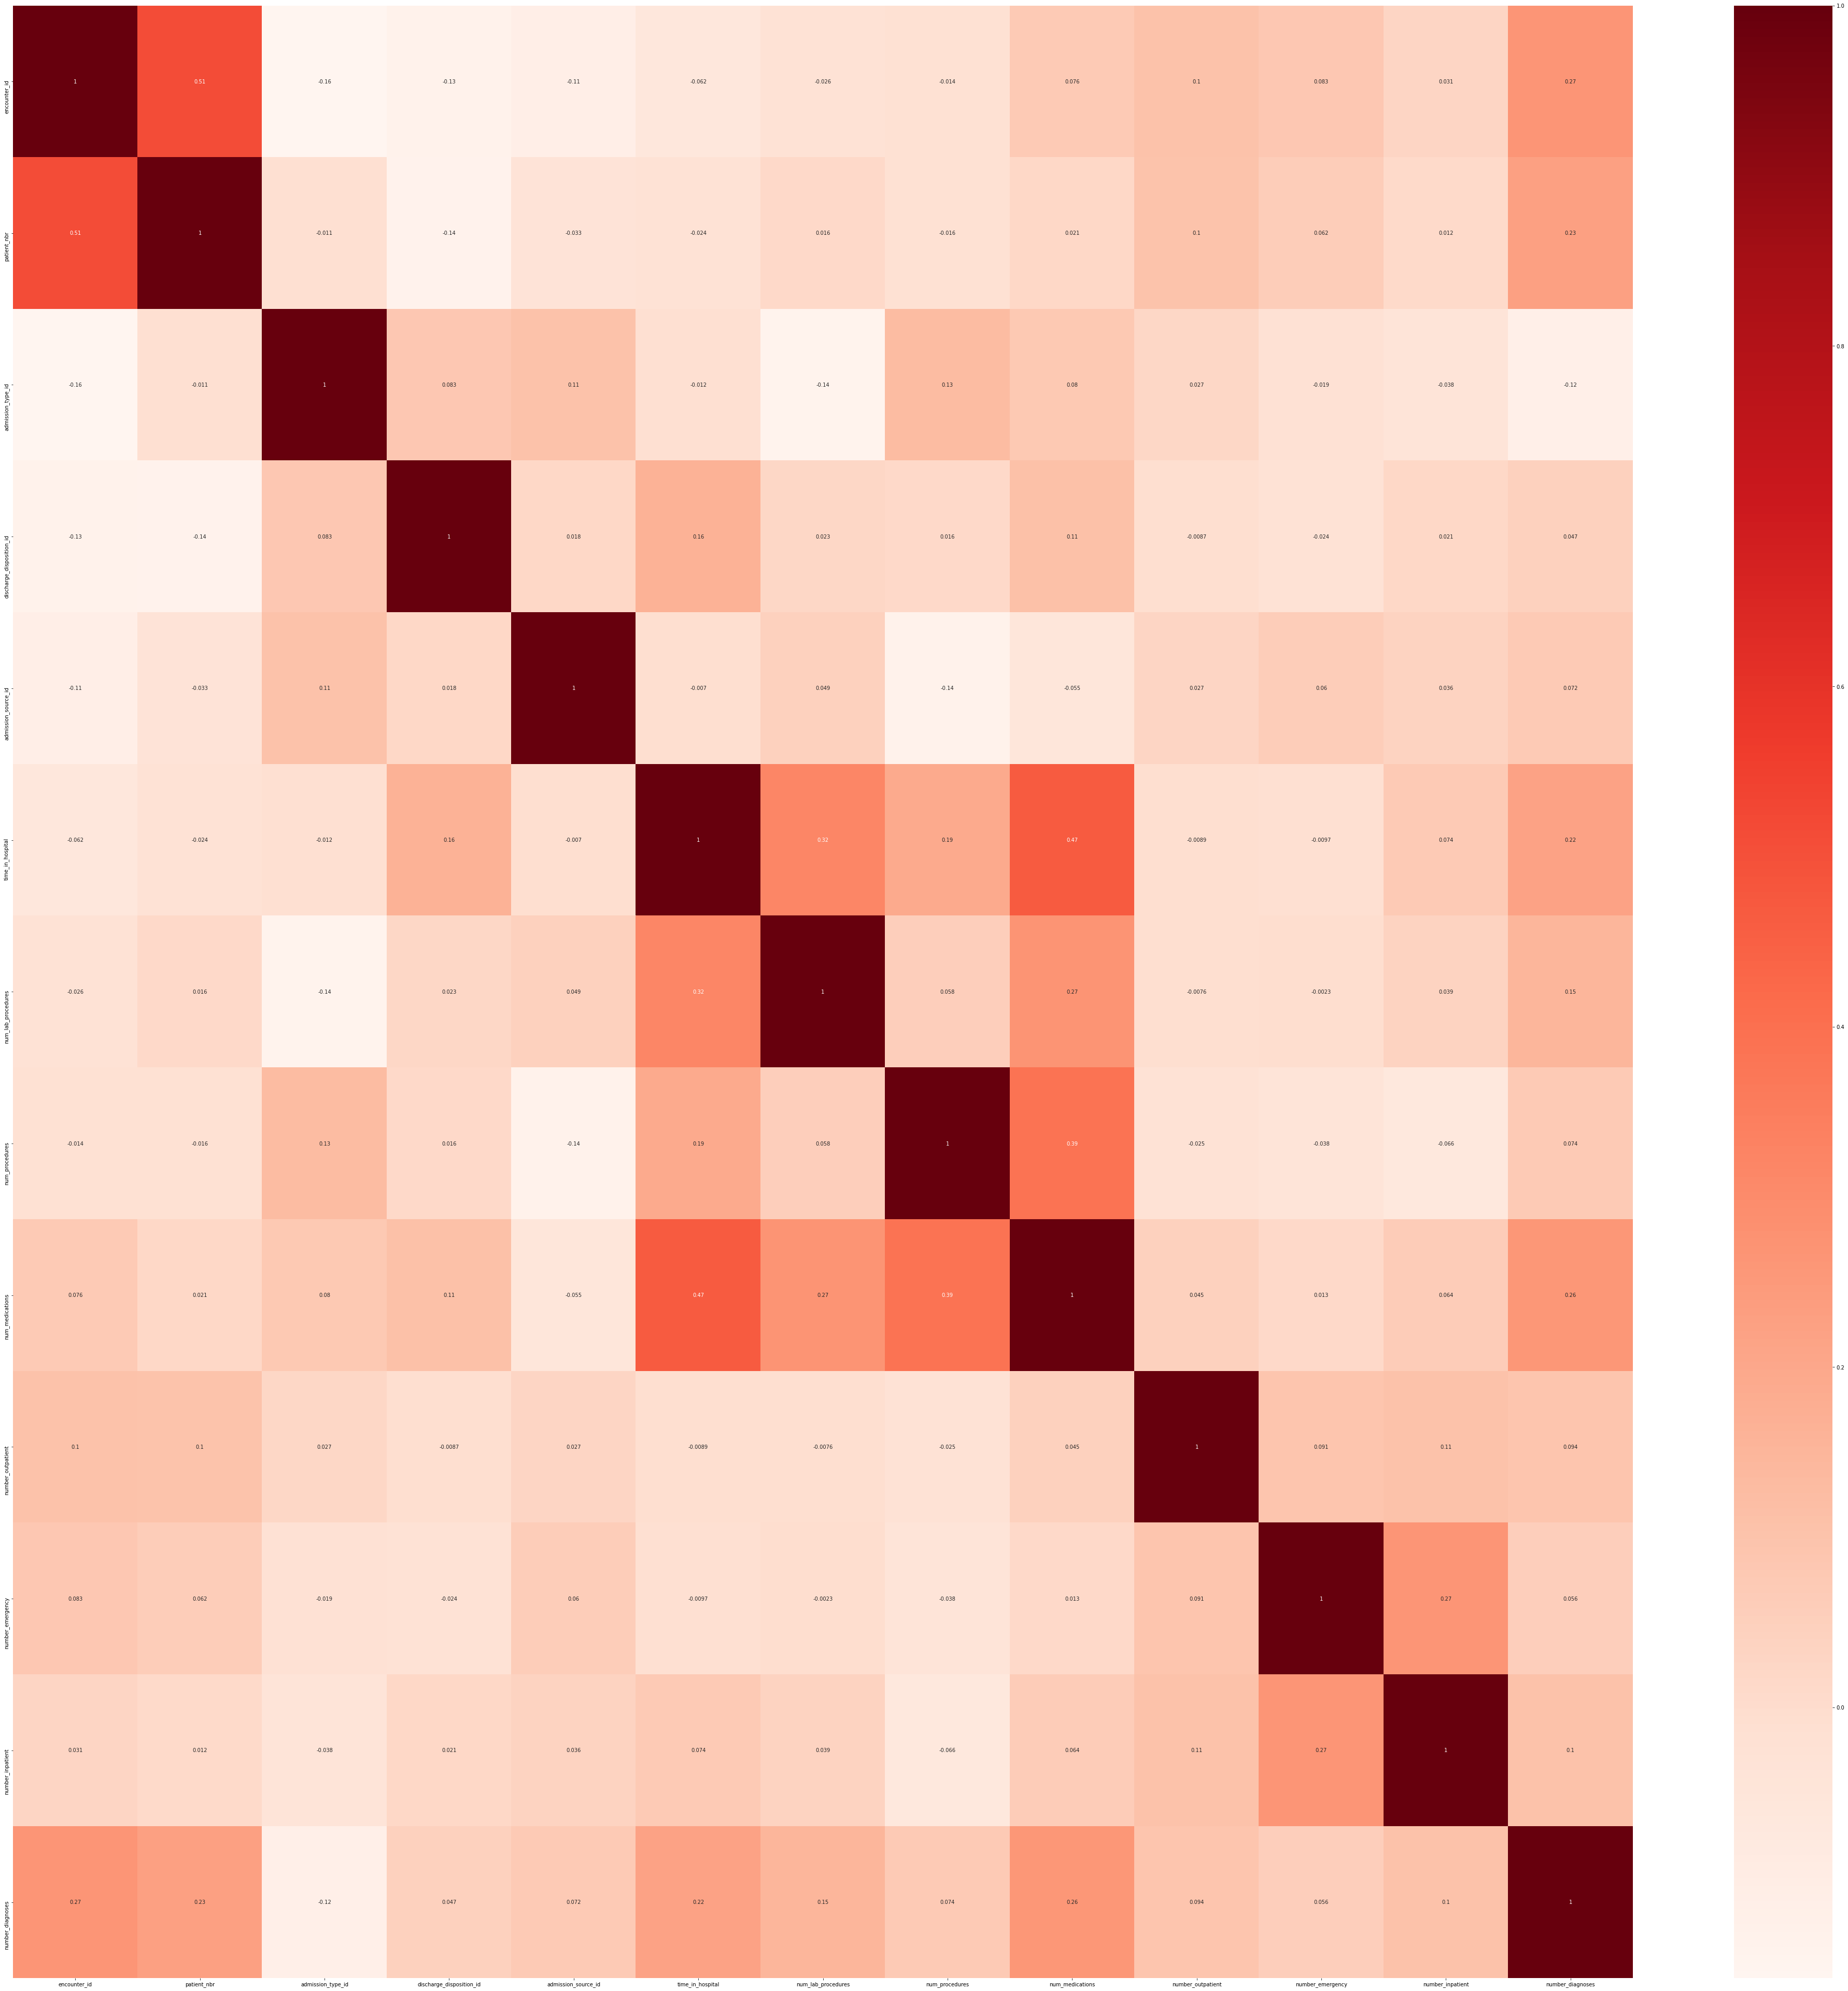

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(70,70))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

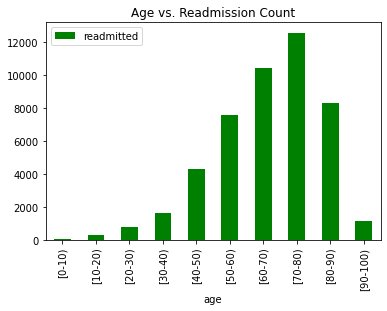

In [ ]:
df_age = data[data.readmitted != 'NO'].groupby('age').count()[['readmitted']].reset_index()
df_age.plot(x='age', y='readmitted',kind="bar", color='green')
plt.title('Age vs. Readmission Count')
plt.show()

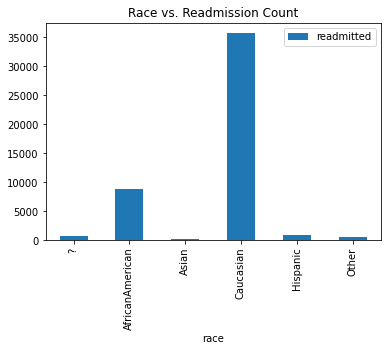

In [ ]:
df_race = data[data.readmitted != 'NO'].groupby('race').count()[['readmitted']].reset_index()
df_race.plot(x='race', y='readmitted',kind="bar")
plt.title('Race vs. Readmission Count')
plt.show()

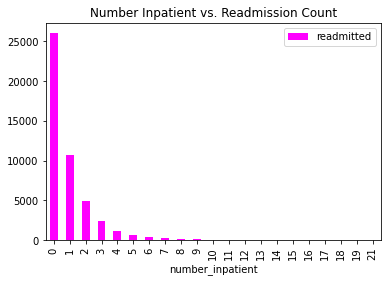

In [ ]:
# Number of inpatient visits = Number of inpatient visits of the patient in the year preceding the encounter
df_number_inpatient = data[data.readmitted != 'NO'].groupby('number_inpatient').count()[['readmitted']].reset_index()
df_number_inpatient.plot(x='number_inpatient', y='readmitted',kind="bar", color='magenta')
plt.title('Number Inpatient vs. Readmission Count')
plt.show()

# Drop columns and Normalize values

In [ ]:
data.isin(['?']).sum(axis=0)

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [ ]:
#drop columsn with a lot of ?
data.drop(['weight','payer_code','medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True, axis=1)
for col_name in data:
  data = data.loc[data[col_name] != '?'] 

In [ ]:
data.isin(['?']).sum(axis=0)

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [ ]:
count_row = data.shape[0]
print(count_row)

98053


In [ ]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30


In [ ]:
# convert readmitted data to be 0 for NO and 1 for <30 or > 30
data["readmitted"].replace({"NO": 0, ">30": 1, "<30": 1}, inplace=True)
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1


In [ ]:
# Convert non numerical data to numerical data
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df
data = handle_non_numerical_data(data)
print(data.head())

   race  gender  age  ...  change  diabetesMed  readmitted
1     1       0    9  ...       1            1           1
2     2       0    3  ...       0            1           0
3     1       2    8  ...       1            1           0
4     1       2    0  ...       1            1           0
5     1       2    5  ...       0            1           1

[5 rows x 45 columns]


# Check that data is balance

In [ ]:
# Check the distribution of values for readmitted to see if the data is balanced
data['readmitted'].value_counts()

0    52338
1    45715
Name: readmitted, dtype: int64

# Extraction and Scaling

In [ ]:
#extracting predictor values & outcome values
x = data.loc[:, data.columns[0:-1]].values
y = data.loc[:, ['readmitted'] ].values
print(x)
print(y)

[[1 0 9 ... 1 1 1]
 [2 0 3 ... 1 0 1]
 [1 2 8 ... 1 1 1]
 ...
 [1 2 7 ... 1 1 1]
 [1 0 4 ... 1 1 1]
 [1 2 7 ... 1 0 0]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
#create training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
y_train=y_train.ravel()
train_data = lightgbm.Dataset(x_train, label=y_train)
test_data = lightgbm.Dataset(x_test, label=y_test)

# Training

In [ ]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

clf = lightgbm.train(params, train_data, 100)

In [ ]:
#Prediction
y_pred=clf.predict(x_test)

#convert into binary values
for i in range(0,len(y_pred)):
    if y_pred[i]>=0.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)

cm
accuracy

0.5819939626335972

# Save the model

In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('diabetes_readmission_model_2.pkl', 'wb')

# dump information to that file
pickle.dump(clf, file)

In [ ]:
loaded_model = pickle.load(open('diabetes_readmission_model_2.pkl', 'rb'))
# result = loaded_model.score(x_test, y_test)
print(loaded_model.dump_model())

EOFError: ignored

# Testing

In [ ]:
import sklearn
# sklearn.utils.multiclass.type_of_target(y_test)
y_pred=y_pred.ravel()
sklearn.utils.multiclass.type_of_target(y_pred)

In [ ]:
data['readmitted'].value_counts(dropna=False).to_string()


In [ ]:
data.isin(['?']).sum(axis=0)

In [ ]:
numerical_summary = data.describe()
numerical_summary.transpose()


In [ ]:
numerical_columns = list(numerical_summary.columns)
cat_columns = list(set(data.columns) - set(numerical_columns) )
print(cat_columns)

In [ ]:
for col in cat_columns:
  print('variable:', col)
  print(data[col].value_counts(dropna=False).to_string())